## Modeling

In [4]:
import scanpy as sc
import numpy as np 
import matplotlib.pyplot as plt

# directory = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/"  # Directory for 1k_PBMCs
directory = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/adata_matrices/"  # Directory for 1k_PBMCs
# directory = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/adata_matrices/"    # Directory for 10k PBMCS

adata_dict = {}
for i in range(1, 13):
    adata_dict[i] = sc.read_h5ad(directory + f"adata_{i}.h5ad")
    
adata_12 = adata_dict[12]
    

Total common barcodes: 1232
Total filtered gene counts: 4283700


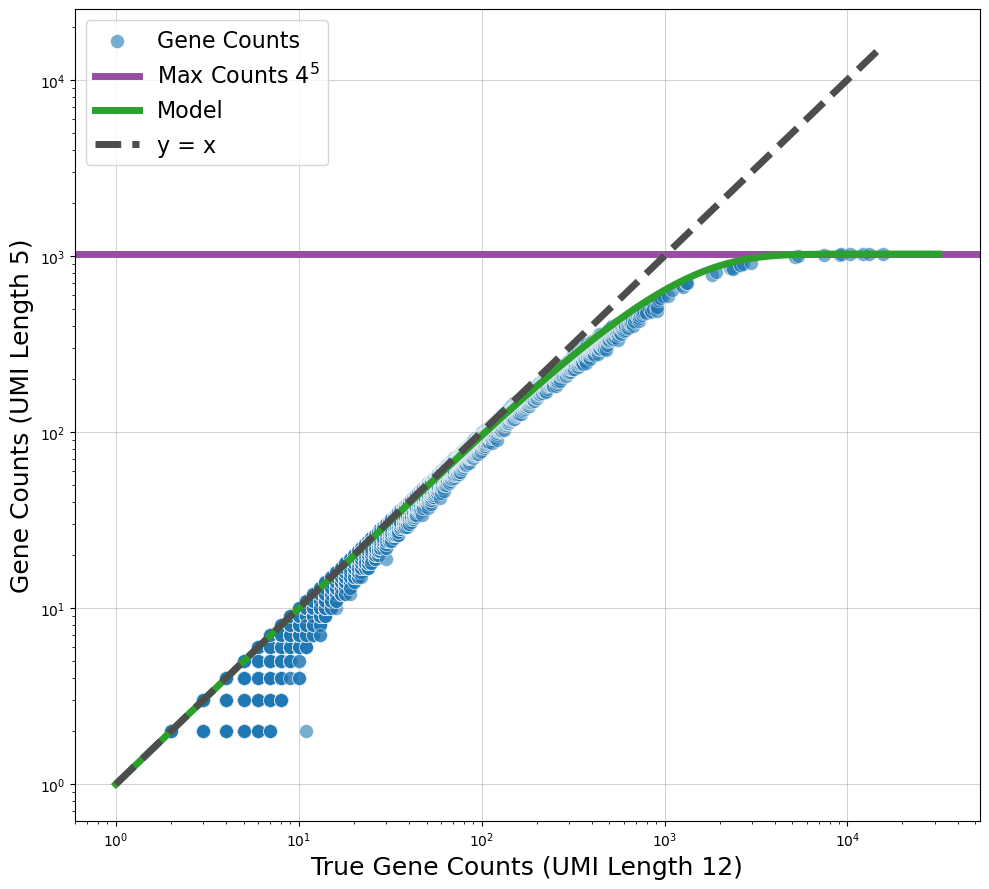

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc

# Your model function
def f(n_vals, j):
    return 4**j * (1 - (1 - 1 / 4**j)**n_vals)

# Fixed UMI length for "true" counts
i = 12
j = 5  # Only generate for UMI 5
n_values = np.logspace(0, 4.5, 200)

# Output directory
save_dir = "/data/dagyeman/cellranger/bam_file_analysis/figures_ur/manuscript_figures"
os.makedirs(save_dir, exist_ok=True)

# Ensure both datasets are properly aligned
common_barcodes = set(adata_dict[i].obs_names).intersection(set(adata_dict[j].obs_names))
print(f"Total common barcodes: {len(common_barcodes)}")

# Initialize lists to hold all gene counts for all common cells
all_gene_counts_i = []
all_gene_counts_j = []

# Extract gene counts for each common barcode
for barcode in common_barcodes:
    # Get the gene counts for this barcode in both datasets
    gene_counts_i = adata_dict[i][barcode].X.toarray().flatten()
    gene_counts_j = adata_dict[j][barcode].X.toarray().flatten()

    # Create a boolean mask for gene_counts_i that are greater than or equal to 1
    mask = gene_counts_i >= 1 

    # Apply the mask to filter gene_counts_i and the corresponding values in gene_counts_j
    filtered_counts_i = gene_counts_i[mask] + 1  # +1 for log scale
    filtered_counts_j = gene_counts_j[mask] + 1

    # Append to the global lists
    all_gene_counts_i.extend(filtered_counts_i)
    all_gene_counts_j.extend(filtered_counts_j)

# Convert lists to numpy arrays
all_gene_counts_i = np.array(all_gene_counts_i)
all_gene_counts_j = np.array(all_gene_counts_j)

print(f"Total filtered gene counts: {len(all_gene_counts_i)}")

# Sort the gene counts based on gene_counts_i
sorted_indices = np.argsort(all_gene_counts_i)
sorted_gene_counts_i = all_gene_counts_i[sorted_indices]
sorted_gene_counts_j = all_gene_counts_j[sorted_indices]

# Create plot
plt.figure(figsize=(10, 9))
plt.scatter(
    sorted_gene_counts_i, 
    sorted_gene_counts_j, 
    alpha=0.6, 
    c='#1f77b4',  # Standard Blue for Points
    edgecolors='w', 
    s=100,             # Increased marker size (was 50)
    linewidth=0.5, 
    label='Gene Counts'
)

# Add the asymptotic line for UMI 5
y_asymptotic_value = 4**j
plt.axhline(
    y=y_asymptotic_value, 
    color='#984ea3', 
    linestyle='-', 
    linewidth=5, 
    label=f'Max Counts $4^{{{j}}}$'
)

# Plot the model
model_vals = f(n_values, j)
plt.plot(
    n_values, 
    model_vals, 
    color='#2ca02c',  # Standard Green for Model Line
    linewidth=5, 
    label='Model'
)

# Reference y = x line
max_val = max(sorted_gene_counts_i.max(), sorted_gene_counts_j.max())
plt.plot([1, max_val], [1, max_val], linestyle='--', color='#4D4D4D', linewidth=5, label='y = x')

# Axis scaling and labels
plt.xscale('log')
plt.yscale('log')
plt.xlabel('True Gene Counts (UMI Length 12)', fontsize=18)
plt.ylabel('Gene Counts (UMI Length 5)', fontsize=18)
plt.grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.5)
plt.legend(loc="upper left",fontsize=16)  # Or any other position

plt.tight_layout()

# Save and show the plot
plt.savefig(f"{save_dir}/UMI_12_vs_{j}_all_cells.jpg", format='jpg', dpi=300)
plt.show()
plt.close()


### Doing it as pdf, samping points 

Total common barcodes: 1232


Total filtered gene counts: 4283700


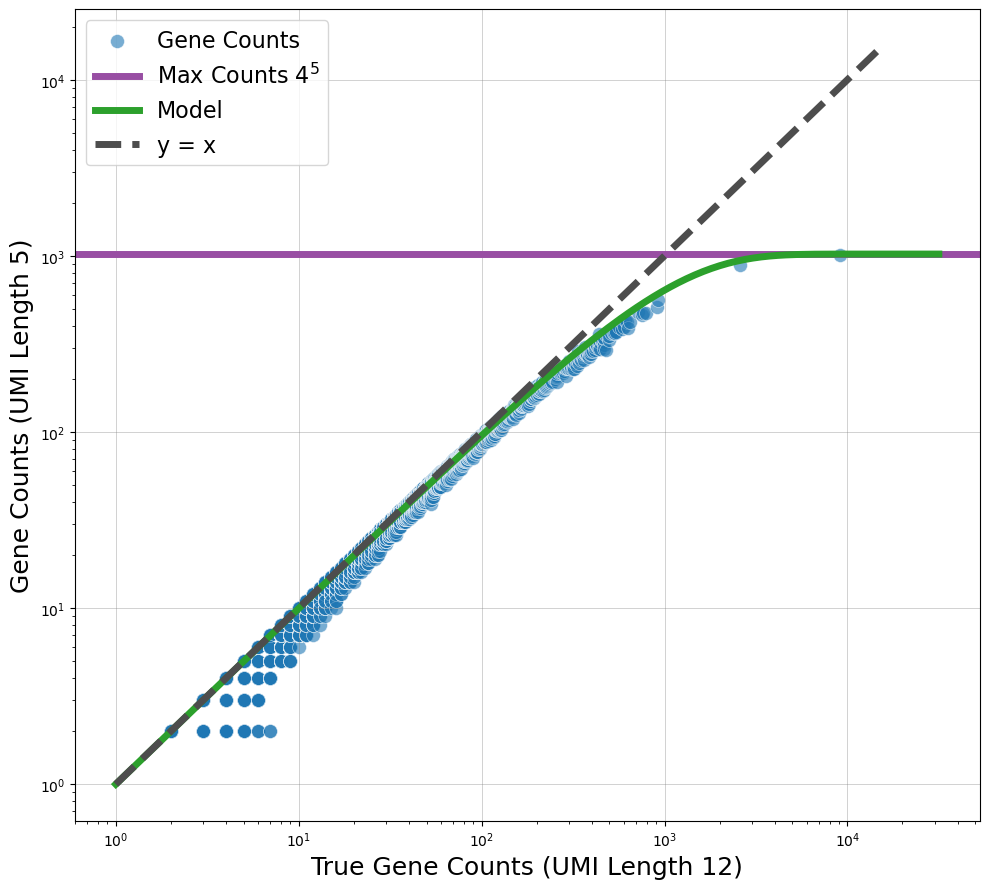

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc

# Your model function
def f(n_vals, j):
    return 4**j * (1 - (1 - 1 / 4**j)**n_vals)

# Fixed UMI length for "true" counts
i = 12
j = 5  # Only generate for UMI 5
n_values = np.logspace(0, 4.5, 200)

# Output directory
save_dir = "/data/dagyeman/cellranger/bam_file_analysis/figures_ur/manuscript_figures"
os.makedirs(save_dir, exist_ok=True)

# Ensure both datasets are properly aligned
common_barcodes = set(adata_dict[i].obs_names).intersection(set(adata_dict[j].obs_names))
print(f"Total common barcodes: {len(common_barcodes)}")

# Initialize lists to hold all gene counts for all common cells
all_gene_counts_i = []
all_gene_counts_j = []

# Extract gene counts for each common barcode
for barcode in common_barcodes:
    # Get the gene counts for this barcode in both datasets
    gene_counts_i = adata_dict[i][barcode].X.toarray().flatten()
    gene_counts_j = adata_dict[j][barcode].X.toarray().flatten()

    # Create a boolean mask for gene_counts_i that are greater than or equal to 1
    mask = gene_counts_i >= 1 

    # Apply the mask to filter gene_counts_i and the corresponding values in gene_counts_j
    filtered_counts_i = gene_counts_i[mask] + 1  # +1 for log scale
    filtered_counts_j = gene_counts_j[mask] + 1

    # Append to the global lists
    all_gene_counts_i.extend(filtered_counts_i)
    all_gene_counts_j.extend(filtered_counts_j)

# Convert lists to numpy arrays
all_gene_counts_i_real = np.array(all_gene_counts_i)
all_gene_counts_j_real = np.array(all_gene_counts_j)

print(f"Total filtered gene counts: {len(all_gene_counts_i)}")

# ─── Randomly Sample 500,000 Points ─────────────────────────────────────────
if len(all_gene_counts_i) > 500000:
    sample_indices = np.random.choice(len(all_gene_counts_i_real), 500000, replace=False)
    all_gene_counts_i = all_gene_counts_i_real[sample_indices]
    all_gene_counts_j = all_gene_counts_j_real[sample_indices]

# Sort the gene counts based on gene_counts_i
sorted_indices = np.argsort(all_gene_counts_i)
sorted_gene_counts_i = all_gene_counts_i[sorted_indices]
sorted_gene_counts_j = all_gene_counts_j[sorted_indices]

# Create plot
plt.figure(figsize=(10, 9))
plt.scatter(
    sorted_gene_counts_i, 
    sorted_gene_counts_j, 
    alpha=0.6, 
    c='#1f77b4',  # Standard Blue for Points
    edgecolors='w', 
    s=100,             # Increased marker size (was 50)
    linewidth=0.5, 
    label='Gene Counts'
)

# Add the asymptotic line for UMI 5
y_asymptotic_value = 4**j
plt.axhline(
    y=y_asymptotic_value, 
    color='#984ea3', 
    linestyle='-', 
    linewidth=5, 
    label=f'Max Counts $4^{{{j}}}$'
)

# Plot the model
model_vals = f(n_values, j)
plt.plot(
    n_values, 
    model_vals, 
    color='#2ca02c',  # Standard Green for Model Line
    linewidth=5, 
    label='Model'
)

# Reference y = x line
max_val = max(all_gene_counts_i_real.max(), all_gene_counts_j_real.max())
plt.plot([1, max_val], [1, max_val], linestyle='--', color='#4D4D4D', linewidth=5, label='y = x')

# Axis scaling and labels
plt.xscale('log')
plt.yscale('log')
plt.xlabel('True Gene Counts (UMI Length 12)', fontsize=18)
plt.ylabel('Gene Counts (UMI Length 5)', fontsize=18)
plt.grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.5)
plt.legend(loc="upper left", fontsize=16)

plt.tight_layout()

# Save and show the plot
plt.savefig(f"{save_dir}/UMI_12_vs_5_all_cells.pdf")
plt.show()
plt.close()


## Inverting Plot

In [7]:
import scanpy as sc
import numpy as np 
import matplotlib.pyplot as plt

# directory = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inverted2_adata_matrices/"  # Directory for 1k_PBMCs
directory = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/inverted2_adata_matrices/"  # Directory for 1k_PBMCs
# directory = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/inverted2_adata_matrices/"    # Directory for 10k PBMCS

adata_dict = {}
for i in range(1, 13):
    adata_dict[i] = sc.read_h5ad(directory + f"adata_inverted_{i}.h5ad")
    
print(adata_dict[6])


# Load the ground truth vector 
# adata_12 = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/adata_matrices/adata_12.h5ad")
# adata_12 = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/adata_12.h5ad")
adata_12 = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/adata_matrices/adata_12.h5ad")
adata_12

AnnData object with n_obs × n_vars = 1232 × 28227


AnnData object with n_obs × n_vars = 1232 × 28227

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function f(n, 4^j) = 4^j * (1 - (1 - 1/4^j)^n)
def f(n_vals, j):
    return 4**j * (1 - (1 - 1 / 4**j)**n_vals)

# Define parameters
i = 12
j = 5

# Ensure both datasets are properly aligned
common_barcodes = set(adata_dict[i].obs_names).intersection(set(adata_dict[j].obs_names))
print(f"Total common barcodes: {len(common_barcodes)}")

# Initialize lists to hold all gene counts for all common cells
all_gene_counts1 = []
all_gene_counts2 = []

# Extract gene counts for each common barcode
for barcode in common_barcodes:
    # Get the gene counts for this barcode in both datasets
    gene_counts1 = adata_dict[i][barcode].X.toarray().flatten()
    gene_counts2 = adata_dict[j][barcode].X.toarray().flatten()

    # Create a boolean mask for gene_counts1 that are greater than or equal to 1
    mask = gene_counts1 >= 1 

    # Apply the mask to filter gene_counts1 and the corresponding values in gene_counts2
    filtered_counts1 = gene_counts1[mask] + 1  # +1 for log scale
    filtered_counts2 = gene_counts2[mask] + 1

    # Append to the global lists
    all_gene_counts1.extend(filtered_counts1)
    all_gene_counts2.extend(filtered_counts2)

# Convert lists to numpy arrays
all_gene_counts1 = np.array(all_gene_counts1)
all_gene_counts2 = np.array(all_gene_counts2)

# Plotting
plt.figure(figsize=(10, 9))
plt.scatter(
    all_gene_counts1, 
    all_gene_counts2, 
    alpha=0.5, 
    c='#1f77b4', 
    edgecolors='w', 
    s=100, 
    linewidth=0.5, 
    label='Gene Counts'
)

# Adding the identity line
max_val = max(all_gene_counts1.max(), all_gene_counts2.max())
plt.plot([1, max_val], [1, max_val], linestyle='--', color='#4D4D4D', linewidth=5, label='y = x')

# Calculate function values for plotting
n_values = np.logspace(0, 4.5, 200)
f_n_4j = f(n_values, j)

# Log scale for both axes
plt.xscale('log')
plt.yscale('log')

# Labels and legend
plt.xlabel('True Gene Counts (UMI Length 12)', fontsize=18)
plt.ylabel(f'Predicted Counts (UMI Length {j})', fontsize=18)
plt.grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.7)
plt.legend(loc="upper left",fontsize=16)  # Or any other position

save_dir = "/data/dagyeman/cellranger/bam_file_analysis/figures_ur/manuscript_figures"
plt.savefig(f"{save_dir}/inverted_UMI_12_vs_{j}_all_cells.jpg", format='jpg', dpi=300)
plt.show()





Total common barcodes: 1232


### Plotting sampling points, pdf


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function f(n, 4^j) = 4^j * (1 - (1 - 1/4^j)^n)
def f(n_vals, j):
    return 4**j * (1 - (1 - 1 / 4**j)**n_vals)

# Define parameters
i = 12
j = 5

# Ensure both datasets are properly aligned
common_barcodes = set(adata_dict[i].obs_names).intersection(set(adata_dict[j].obs_names))
print(f"Total common barcodes: {len(common_barcodes)}")

# Initialize lists to hold all gene counts for all common cells
all_gene_counts1 = []
all_gene_counts2 = []

# Extract gene counts for each common barcode
for barcode in common_barcodes:
    # Get the gene counts for this barcode in both datasets
    gene_counts1 = adata_dict[i][barcode].X.toarray().flatten()
    gene_counts2 = adata_dict[j][barcode].X.toarray().flatten()

    # Create a boolean mask for gene_counts1 that are greater than or equal to 1
    mask = gene_counts1 >= 1 

    # Apply the mask to filter gene_counts1 and the corresponding values in gene_counts2
    filtered_counts1 = gene_counts1[mask] + 1  # +1 for log scale
    filtered_counts2 = gene_counts2[mask] + 1

    # Append to the global lists
    all_gene_counts1.extend(filtered_counts1)
    all_gene_counts2.extend(filtered_counts2)

# Convert lists to numpy arrays
all_gene_counts1_real = np.array(all_gene_counts1)
all_gene_counts2_real = np.array(all_gene_counts2)

# ─── Randomly Sample 500,000 Points ─────────────────────────────────────────
if len(all_gene_counts1) > 500000:
    sample_indices = np.random.choice(len(all_gene_counts1_real), 500000, replace=False)
    all_gene_counts1 = all_gene_counts1_real[sample_indices]
    all_gene_counts2 = all_gene_counts2_real[sample_indices]

# Plotting
plt.figure(figsize=(10, 9))
plt.scatter(
    all_gene_counts1, 
    all_gene_counts2, 
    alpha=0.5, 
    c='#1f77b4', 
    edgecolors='w', 
    s=100, 
    linewidth=0.5, 
    label='Gene Counts'
)

# Adding the identity line
max_val = max(all_gene_counts1_real.max(), all_gene_counts2_real.max())
plt.plot([1, max_val], [1, max_val], linestyle='--', color='#4D4D4D', linewidth=5, label='y = x')

# Calculate function values for plotting
n_values = np.logspace(0, 4.5, 200)
f_n_4j = f(n_values, j)

# Log scale for both axes
plt.xscale('log')
plt.yscale('log')

# Labels and legend
plt.xlabel('True Gene Counts (UMI Length 12)', fontsize=18)
plt.ylabel(f'Predicted Counts (UMI Length {j})', fontsize=18)
plt.grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.7)
plt.legend(loc="upper left", fontsize=16)  # Or any other position

# Save as a high-resolution PDF
save_dir = "/data/dagyeman/cellranger/bam_file_analysis/figures_ur/manuscript_figures"
plt.savefig(f"{save_dir}/inverted_UMI_12_vs_{j}_all_cells.pdf")
plt.show()


## Confusion Matrices

#### Naive


Processing UMI length = 3 …


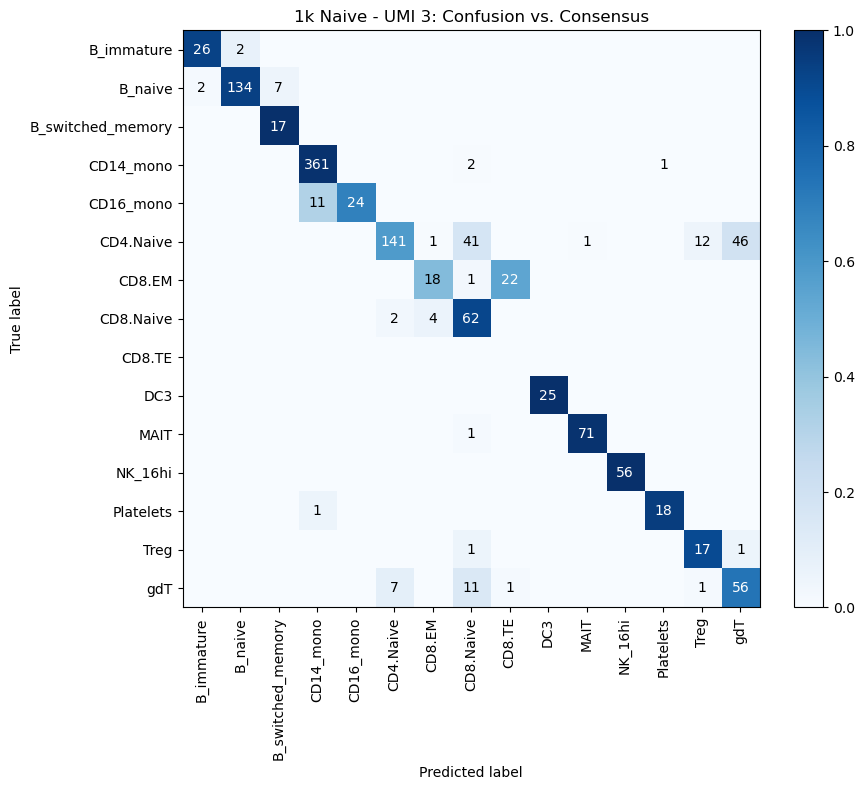

In [20]:
import os
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from collections import Counter
import numpy as np

# ──────────────────────────────────────────────────────────────────────────────
# 0) Paths
base_path = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/adata_matrices/cell_annotations/annotated_adata_matrices"

# ──────────────────────────────────────────────────────────────────────────────
# 1) Build consensus from UMI 8–12

# load the five Adatas
ensemble_adatas = {
    i: sc.read_h5ad(os.path.join(base_path, f"annotated_adata_{i}.h5ad"))
    for i in range(8, 13)
}

# intersect on common cells
common = set(ensemble_adatas[8].obs_names)
for ad in ensemble_adatas.values():
    common &= set(ad.obs_names)
common_cells = sorted(common)

# majority-vote consensus labels
consensus_labels = {}
for cell in common_cells:
    votes = [ensemble_adatas[i].obs.loc[cell, 'majority_voting'] for i in range(8, 13)]
    consensus_labels[cell] = Counter(votes).most_common(1)[0][0]

# ──────────────────────────────────────────────────────────────────────────────
# 2) Exclude these three from the axes
exclude = {"Plasma_cell_IgG", "CD4.Prolif", "pDC"}

# ──────────────────────────────────────────────────────────────────────────────
# 3) Only process UMI length of 3
umi = 3
print(f"\nProcessing UMI length = {umi} …")

# load this UMI’s AnnData
adata = sc.read_h5ad(os.path.join(base_path, f"annotated_adata_{umi}.h5ad"))

# align to consensus cells
if not all(adata.obs_names == common_cells):
    cells = [c for c in common_cells if c in adata.obs_names]
    print(f"  Aligning to {len(cells)} common cells")
    adata = adata[cells].copy()

# extract true vs. pred
y_true = np.array([consensus_labels[c] for c in adata.obs_names], dtype=str)
y_pred = adata.obs['majority_voting'].astype(str).values

# determine labels (minus excludes)
labs = np.unique(np.concatenate([y_true, y_pred]))
labels = [L for L in labs if L not in exclude]
n = len(labels)

# raw confusion counts
cm = confusion_matrix(y_true, y_pred, labels=labels)

# row-normalize to get proportions, but set rows with sum=0 to zeros
row_sums = cm.sum(axis=1, keepdims=True)
cm_prop = np.divide(
    cm.astype(float),
    row_sums,
    out=np.zeros_like(cm, dtype=float),
    where=row_sums != 0
)

# ─── Plot ──────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cm_prop, cmap="Blues", vmin=0, vmax=1)

# ticks & labels
ax.set_xticks(np.arange(n))
ax.set_yticks(np.arange(n))
ax.set_xticklabels(labels, rotation=90, ha="center")
ax.set_yticklabels(labels)
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title(f"1k Naive - UMI {umi}: Confusion vs. Consensus")

# annotate with raw counts, text color by proportion
thresh = 0.5
for r in range(n):
    for c in range(n):
        count = cm[r, c]
        if count == 0:
            continue
        color = "white" if cm_prop[r, c] > thresh else "black"
        ax.text(c, r, str(count), ha="center", va="center", color=color)

# colorbar
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig(f"/data/dagyeman/cellranger/bam_file_analysis/figures_ur/manuscript_figures/confusion_matrix_UMI_{umi}.pdf")
plt.show()




Processing UMI length = 3 …


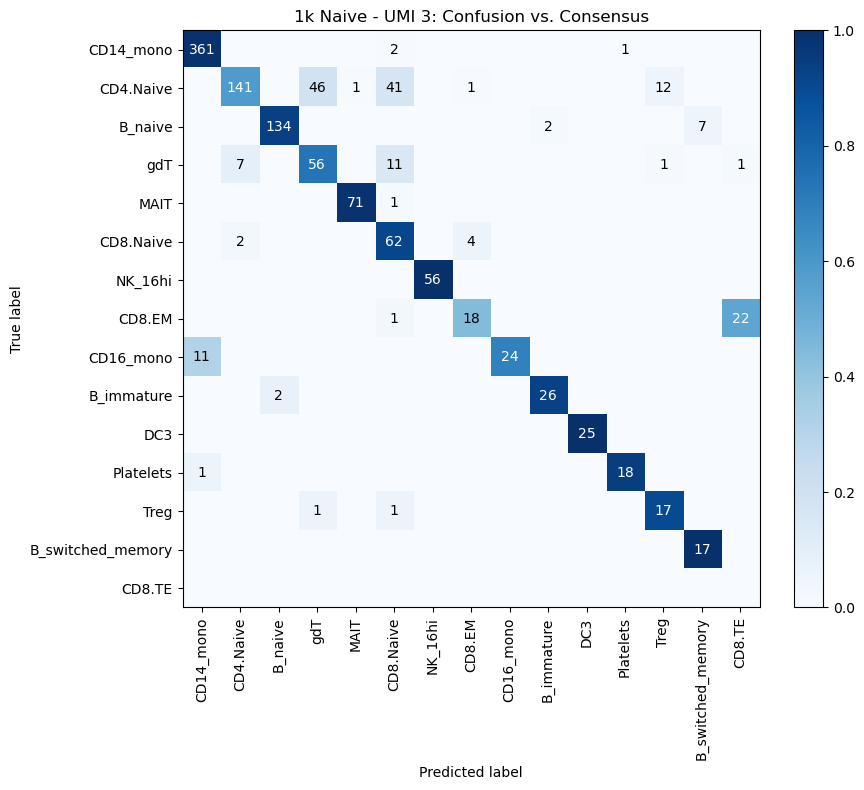

In [25]:
import os
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from collections import Counter
import numpy as np

# ──────────────────────────────────────────────────────────────────────────────
# 0) Paths
base_path = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/adata_matrices/cell_annotations/annotated_adata_matrices"

# ──────────────────────────────────────────────────────────────────────────────
# 1) Build consensus from UMI 8–12

ensemble_adatas = {
    i: sc.read_h5ad(os.path.join(base_path, f"annotated_adata_{i}.h5ad"))
    for i in range(8, 13)
}

common = set(ensemble_adatas[8].obs_names)
for ad in ensemble_adatas.values():
    common &= set(ad.obs_names)
common_cells = sorted(common)

consensus_labels = {}
for cell in common_cells:
    votes = [ensemble_adatas[i].obs.loc[cell, 'majority_voting'] for i in range(8, 13)]
    consensus_labels[cell] = Counter(votes).most_common(1)[0][0]

# ──────────────────────────────────────────────────────────────────────────────
# 2) Exclude these three from the axes
exclude = {"Plasma_cell_IgG", "CD4.Prolif", "pDC"}

# ──────────────────────────────────────────────────────────────────────────────
# 3) Only process UMI length of 3
umi = 3
print(f"\nProcessing UMI length = {umi} …")

adata = sc.read_h5ad(os.path.join(base_path, f"annotated_adata_{umi}.h5ad"))
if not all(adata.obs_names == common_cells):
    cells = [c for c in common_cells if c in adata.obs_names]
    print(f"  Aligning to {len(cells)} common cells")
    adata = adata[cells].copy()

y_true = np.array([consensus_labels[c] for c in adata.obs_names], dtype=str)
y_pred = adata.obs['majority_voting'].astype(str).values

labs = np.unique(np.concatenate([y_true, y_pred]))
labels = [L for L in labs if L not in exclude]
n = len(labels)

cm = confusion_matrix(y_true, y_pred, labels=labels)

row_sums = cm.sum(axis=1, keepdims=True)
cm_prop = np.divide(
    cm.astype(float),
    row_sums,
    out=np.zeros_like(cm, dtype=float),
    where=row_sums != 0
)

# ─── REORDER BOTH ROWS & COLUMNS by total true-counts ─────────────────────────
total_counts = cm.sum(axis=1)
order = np.argsort(-total_counts)
cm = cm[order][:, order]
cm_prop = cm_prop[order][:, order]
labels = [labels[idx] for idx in order]
# ──────────────────────────────────────────────────────────────────────────────

# ─── Plot ──────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cm_prop, cmap="Blues", vmin=0, vmax=1)

ax.set_xticks(np.arange(n))
ax.set_yticks(np.arange(n))
ax.set_xticklabels(labels, rotation=90, ha="center")
ax.set_yticklabels(labels)
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title(f"1k Naive - UMI {umi}: Confusion vs. Consensus")

thresh = 0.5
for r in range(n):
    for c in range(n):
        count = cm[r, c]
        if count == 0:
            continue
        color = "white" if cm_prop[r, c] > thresh else "black"
        ax.text(c, r, str(count), ha="center", va="center", color=color)

cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig(f"/data/dagyeman/cellranger/bam_file_analysis/figures_ur/manuscript_figures/naive_confusion_matrix_UMI_{umi}.pdf")
plt.show()


### Model

Uniform consensus:   1028/1232 = 83.44%
Mixed consensus:     204/1232 = 16.56%

Processing UMI length = 3 …


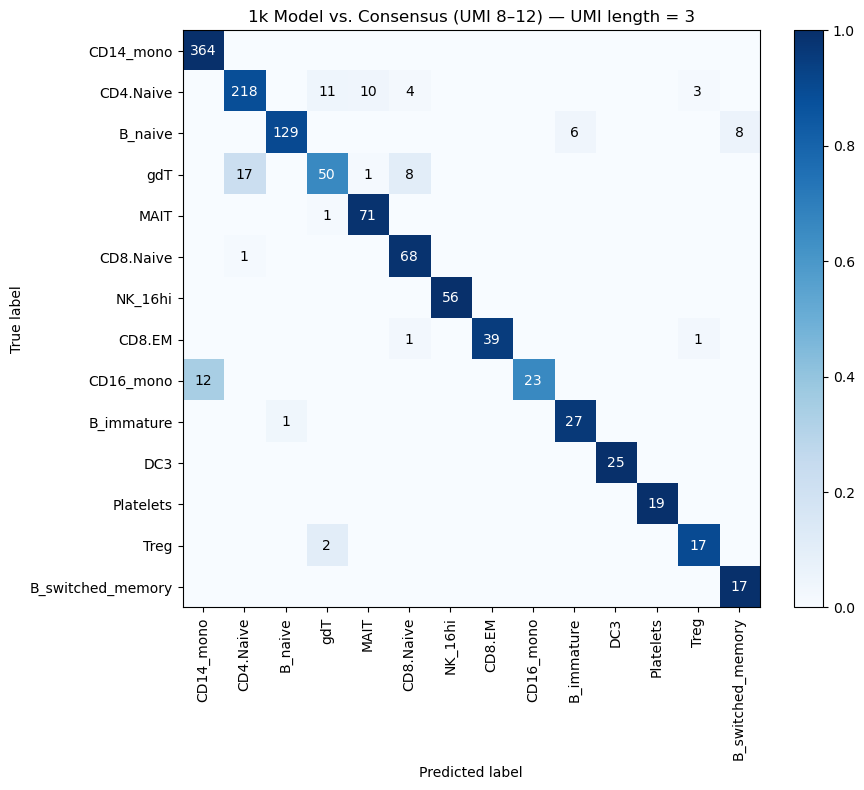

In [26]:
import os
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from collections import Counter
import numpy as np

# ──────────────────────────────────────────────────────────────────────────────
# 0) Paths
model_common_path     = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/inverted2_adata_matrices/cell_annotations/annotated_inv_matrices"
consensus_base_path   = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/adata_matrices/cell_annotations/annotated_adata_matrices"

# ──────────────────────────────────────────────────────────────────────────────
# 1) Load ground‐truth Adatas (UMI 8–12) and build consensus

ensemble_adatas = {
    i: sc.read_h5ad(os.path.join(consensus_base_path, f"annotated_adata_{i}.h5ad"))
    for i in range(8, 13)
}

common = set(ensemble_adatas[8].obs_names)
for ad in ensemble_adatas.values():
    common &= set(ad.obs_names)
common_cells = sorted(common)

consensus_labels = {}
for cell in common_cells:
    votes = [ensemble_adatas[i].obs.loc[cell, 'majority_voting'] for i in range(8, 13)]
    consensus_labels[cell] = Counter(votes).most_common(1)[0][0]

# ──────────────────────────────────────────────────────────────────────────────
# 2) Exclude these from the axes
exclude = {"Plasma_cell_IgG", "CD4.Prolif", "pDC"}

# ──────────────────────────────────────────────────────────────────────────────
# 3) Print uniform‐vote stats once
total       = len(common_cells)
uniform     = sum(
    1 for c in common_cells
      if len({ensemble_adatas[i].obs.loc[c, 'majority_voting'] for i in range(8, 13)}) == 1
)
non_uniform = total - uniform
print(f"Uniform consensus:   {uniform}/{total} = {uniform/total*100:.2f}%")
print(f"Mixed consensus:     {non_uniform}/{total} = {non_uniform/total*100:.2f}%\n")

# ──────────────────────────────────────────────────────────────────────────────
# 4) Only process UMI length of 3
umi = 3
print(f"Processing UMI length = {umi} …")
    
# load inverted‐model AnnData
inv_file = os.path.join(model_common_path, f"annotated_adata_{umi}.h5ad")
inv_adata = sc.read_h5ad(inv_file)
    
# align to consensus cells
if not all(inv_adata.obs_names == common_cells):
    cells = [c for c in common_cells if c in inv_adata.obs_names]
    print(f"  Aligning to {len(cells)} common cells")
    inv_adata = inv_adata[cells].copy()
    
# extract true vs. pred
y_true = np.array([consensus_labels[c] for c in inv_adata.obs_names], dtype=str)
y_pred = inv_adata.obs['majority_voting'].astype(str).values

# determine labels (minus excluded)
labs   = np.unique(np.concatenate([y_true, y_pred]))
labels = [L for L in labs if L not in exclude]
n      = len(labels)
    
# raw confusion counts
cm = confusion_matrix(y_true, y_pred, labels=labels)
    
# row‐normalize (safe divide: zero‐rows → all zeros)
row_sums = cm.sum(axis=1, keepdims=True)
cm_prop = np.divide(
    cm.astype(float),
    row_sums,
    out=np.zeros_like(cm, dtype=float),
    where=row_sums != 0
)

# ─── NEW: reorder BOTH rows & columns by descending true‐label totals ────────
total_counts = cm.sum(axis=1)
order = np.argsort(-total_counts)
cm       = cm[order][:, order]
cm_prop  = cm_prop[order][:, order]
labels   = [labels[idx] for idx in order]
# ──────────────────────────────────────────────────────────────────────────────

# ─── Plot ──────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cm_prop, cmap="Blues", vmin=0, vmax=1)
    
# ticks & labels
ax.set_xticks(np.arange(n))
ax.set_yticks(np.arange(n))
ax.set_xticklabels(labels, rotation=90, ha="center")
ax.set_yticklabels(labels)
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title(f"1k Model vs. Consensus (UMI 8–12) — UMI length = {umi}")
    
# annotate with raw counts; text white if prop>0.5
thresh = 0.5
for r in range(n):
    for c in range(n):
        cnt = cm[r, c]
        if cnt == 0:
            continue
        color = "white" if cm_prop[r, c] > thresh else "black"
        ax.text(c, r, str(cnt), ha="center", va="center", color=color)
    
# colorbar
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
plt.tight_layout()
plt.savefig(f"/data/dagyeman/cellranger/bam_file_analysis/figures_ur/manuscript_figures/model_confusion_matrix_UMI_{umi}.pdf")
plt.show()



## TVD Plot

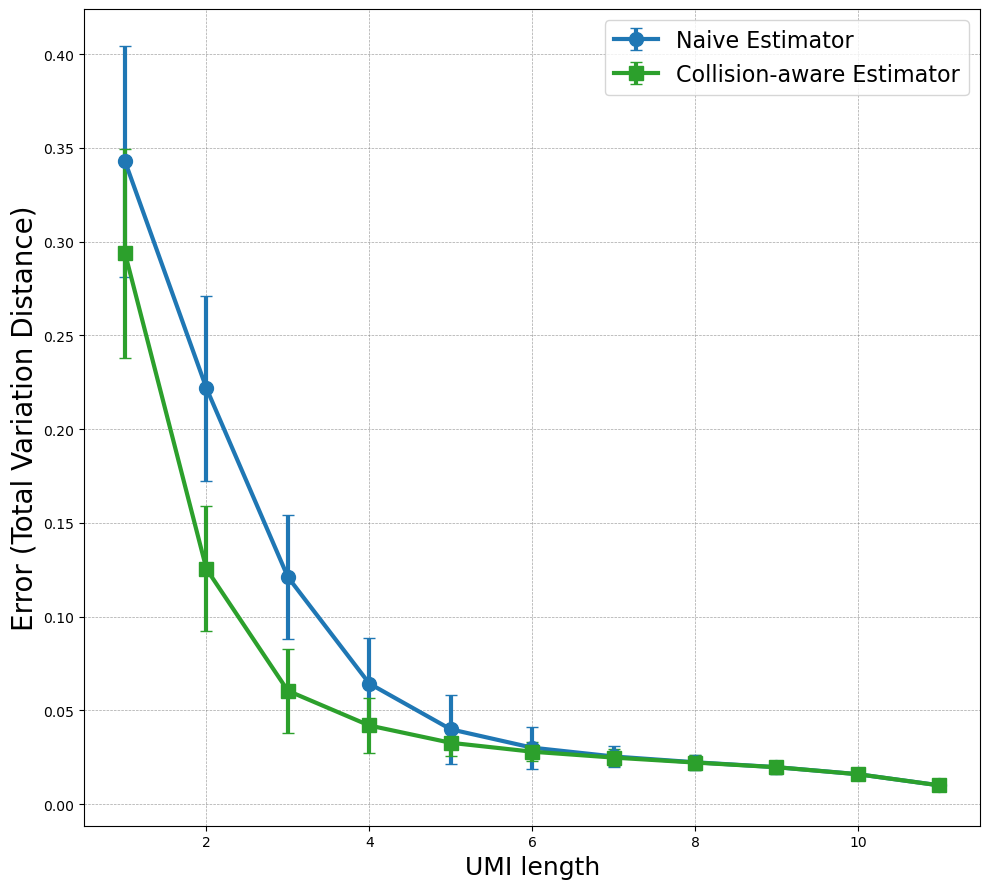

In [23]:
import numpy as np
import scanpy as sc

def tvd(p, q):
    """
    Calculate the Total Variation Distance (TVD) between two probability distributions p and q.
    Assumes that p and q are numpy arrays with the same length.
    """
    p = np.array(p, dtype=np.float64)
    q = np.array(q, dtype=np.float64)
    
    # Check for NaN or infinite values in p and q
    if np.isnan(p).any() or np.isinf(p).any():
        raise ValueError("Input array p contains NaN or infinite values.")
    if np.isnan(q).any() or np.isinf(q).any():
        raise ValueError("Input array q contains NaN or infinite values.")
    
    # Check if sums are zero to avoid division by zero
    sum_p = np.sum(p)
    sum_q = np.sum(q)
    if sum_p == 0 or sum_q == 0:
        raise ValueError("Sum of the input arrays should not be zero.")
    
    # Ensure both vectors are normalized
    p = p / sum_p
    q = q / sum_q
    
    # Compute the Total Variation Distance
    return 0.5 * np.sum(np.abs(p - q))

# Loading the regular adata matrices
# common_path = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices"
common_path = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/adata_matrices"
regular_adata_dict = {}
for i in range(1, 13):
    path = f"{common_path}/adata_{i}.h5ad"
    regular_adata_dict[i] = sc.read_h5ad(path)

# Loading the inverted adata matrices
# common_path2 = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inverted2_adata_matrices"
common_path2 = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/inverted2_adata_matrices"
inverted_adata_dict = {}
for i in range(1, 13):
    path = f"{common_path2}/adata_inverted_{i}.h5ad"
    inverted_adata_dict[i] = sc.read_h5ad(path)

# This is the ground truth adata matrix
gt_adata12 = regular_adata_dict[12]

# Initialize lists to store the mean and standard deviation of errors
mean_errors = []
std_errors = []
mean_errors2 = []
std_errors2 = []

# Compute TVD for regular and inverted matrices against the ground truth
for i in range(1, 13):
    # Errors for regular matrices
    errors = []
    for barcode in gt_adata12.obs_names:
        index1 = np.where(regular_adata_dict[i].obs_names == barcode)[0][0]
        index_gt = np.where(gt_adata12.obs_names == barcode)[0][0]
        
        # Extract gene counts
        gene_counts1 = regular_adata_dict[i].X[index1]
        gene_counts_gt = gt_adata12.X[index_gt]
        
        # Convert to dense array if necessary
        if not isinstance(gene_counts1, np.ndarray):
            gene_counts1 = gene_counts1.toarray().flatten()
        else:
            gene_counts1 = gene_counts1.flatten()
        
        if not isinstance(gene_counts_gt, np.ndarray):
            gene_counts_gt = gene_counts_gt.toarray().flatten()
        else:
            gene_counts_gt = gene_counts_gt.flatten()
        
        # Filter for non-zero counts in gene_counts1
        mask = gene_counts1 >= 1
        gene_counts1 = gene_counts1[mask]
        gene_counts_gt = gene_counts_gt[mask]
        
        # Sort the gene counts
        sorted_indices = np.argsort(gene_counts1)
        sorted_gene_counts1 = gene_counts1[sorted_indices]
        sorted_gene_counts_gt = gene_counts_gt[sorted_indices]
        
        # Compute TVD
        error = tvd(sorted_gene_counts1, sorted_gene_counts_gt)
        errors.append(error)
    
    mean_errors.append(np.mean(errors))
    std_errors.append(np.std(errors))

    # Errors for inverted matrices
    errors2 = []
    for barcode in gt_adata12.obs_names:
        index2 = np.where(inverted_adata_dict[i].obs_names == barcode)[0][0]
        index_gt = np.where(gt_adata12.obs_names == barcode)[0][0]
        
        # Extract gene counts
        gene_counts2 = inverted_adata_dict[i].X[index2]
        gene_counts_gt = gt_adata12.X[index_gt]
        
        # Convert to dense array if necessary
        if not isinstance(gene_counts2, np.ndarray):
            gene_counts2 = gene_counts2.toarray().flatten()
        else:
            gene_counts2 = gene_counts2.flatten()
        
        if not isinstance(gene_counts_gt, np.ndarray):
            gene_counts_gt = gene_counts_gt.toarray().flatten()
        else:
            gene_counts_gt = gene_counts_gt.flatten()
        
        # Filter for non-zero counts in gene_counts2
        mask = gene_counts2 >= 1
        gene_counts2 = gene_counts2[mask]
        gene_counts_gt = gene_counts_gt[mask]
        
        # Sort the gene counts
        sorted_indices = np.argsort(gene_counts2)
        sorted_gene_counts2 = gene_counts2[sorted_indices]
        sorted_gene_counts_gt = gene_counts_gt[sorted_indices]
        
        # Compute TVD
        error2 = tvd(sorted_gene_counts2, sorted_gene_counts_gt)
        errors2.append(error2)
    
    mean_errors2.append(np.mean(errors2))
    std_errors2.append(np.std(errors2))

import matplotlib.pyplot as plt

# Plotting the errors in log scale
num_experiments = len(mean_errors)  # or set this to 13 if you know the length

plt.figure(figsize=(10, 9))

# Plot errors for the Regular Matrices (Naive Estimator) - BLUE
plt.errorbar(
    range(1, num_experiments), 
    mean_errors[:-1], 
    yerr=std_errors[:-1], 
    fmt='o-', 
    color='#1f77b4',        # Blue for Naive Estimator
    ecolor='#1f77b4',
    linewidth=3,
    elinewidth=3, 
    capsize=4, 
    markersize=10,
    label='Naive Estimator'
)

# Plot errors for the Inverted Matrices (Collision-aware Estimator) - GREEN
plt.errorbar(
    range(1, num_experiments), 
    mean_errors2[:-1], 
    yerr=std_errors2[:-1], 
    fmt='s-', 
    color='#2ca02c',        # Green for Collision-aware Estimator
    ecolor='#2ca02c',
    linewidth=3,
    elinewidth=3, 
    capsize=4, 
    markersize=10,
    label='Collision-aware Estimator'
)

# Labels and grid
plt.xlabel('UMI length', fontsize=18)
plt.ylabel('Error (Total Variation Distance)', fontsize=20)
plt.legend(fontsize=16)  
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
plt.tight_layout()

# Save and show
plt.savefig("/data/dagyeman/cellranger/bam_file_analysis/figures_ur/manuscript_figures/1k_tvd_plot.pdf")
plt.show()


## Celltypist Accuracy Plot

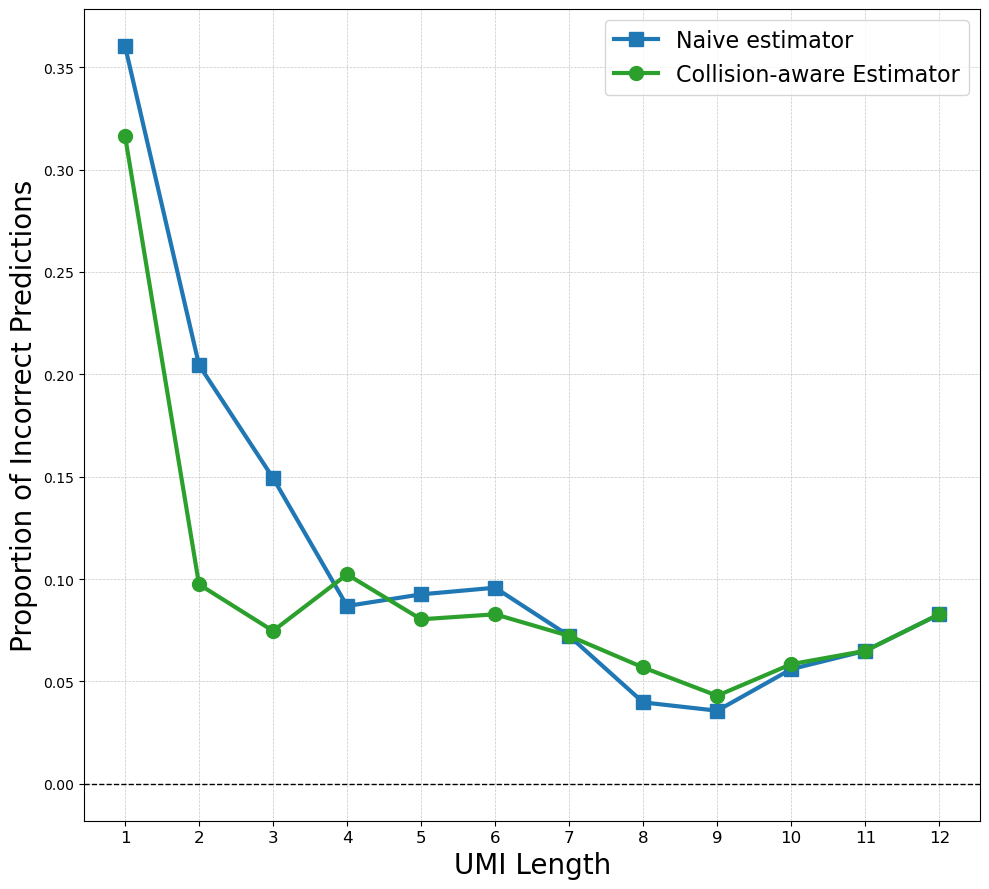

In [24]:
import os
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Paths
regular_path = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/adata_matrices/cell_annotations/annotated_adata_matrices"
inverted_path = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/inverted2_adata_matrices/cell_annotations/annotated_inv_matrices"

# 1) Load regular annotated adata matrices into a dict
annotated_ads_reg = {
    i: sc.read_h5ad(f"{regular_path}/annotated_adata_{i}.h5ad")
    for i in range(1, 13)
}

# 2) Build consensus ground truth from UMI 8–12
#    a) find common cells across UMI 8–12
cells_8_12 = set(annotated_ads_reg[8].obs_names) 
for i in range(9, 13):
    cells_8_12 &= set(annotated_ads_reg[i].obs_names)
common_cells = sorted(cells_8_12)

#    b) majority‐vote per cell
consensus_labels = {}
for cell in common_cells:
    votes = [annotated_ads_reg[i].obs.loc[cell, 'majority_voting'] for i in range(8, 13)]
    consensus_labels[cell] = Counter(votes).most_common(1)[0][0]

# 3) Prepare ground truth array aligned to common_cells
ground_truth = np.array([consensus_labels[cell] for cell in common_cells], dtype=str)

# 4) Compute error vectors
error_vector_reg = np.zeros(12)
error_vector_inv = np.zeros(12)

for i in range(1, 13):
    # Regular predictions aligned to consensus cells
    ad_reg = annotated_ads_reg[i]
    present = [c for c in common_cells if c in ad_reg.obs_names]
    preds_reg = ad_reg.obs.loc[present, 'majority_voting'].astype(str).values
    true_aligned = np.array([consensus_labels[c] for c in present], dtype=str)
    error_vector_reg[i - 1] = np.mean(preds_reg != true_aligned)

    # Inverted predictions aligned to consensus cells
    ad_inv = sc.read_h5ad(f"{inverted_path}/annotated_adata_{i}.h5ad")
    present_inv = [c for c in common_cells if c in ad_inv.obs_names]
    preds_inv = ad_inv.obs.loc[present_inv, 'majority_voting'].astype(str).values
    true_aligned_inv = np.array([consensus_labels[c] for c in present_inv], dtype=str)
    error_vector_inv[i - 1] = np.mean(preds_inv != true_aligned_inv)

# 5) Plot both error curves
plt.figure(figsize=(10, 9))

# Blue for Naive (Regular)
plt.plot(
    range(1, 13), error_vector_reg, marker='s', linestyle='-',
    label='Naive estimator', markersize=10, linewidth=3, color='#1f77b4'
)

# Green for Collision-aware (Inverted)
plt.plot(
    range(1, 13), error_vector_inv, marker='o', linestyle='-',
    label='Collision-aware Estimator', markersize=10, linewidth=3, color='#2ca02c'
)

plt.xlabel('UMI Length', fontsize=20)
plt.ylabel('Proportion of Incorrect Predictions', fontsize=20)
plt.xticks(range(1, 13), fontsize=12)
plt.axhline(y=0, color='k', linestyle='--', linewidth=1)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(fontsize=16)
plt.tight_layout()

out_file = "/data/dagyeman/cellranger/bam_file_analysis/figures_ur/manuscript_figures/1k_error_plot_consensus.pdf"
os.makedirs(os.path.dirname(out_file), exist_ok=True)
plt.savefig(out_file)
plt.show()
